# ` Binary Classification ` Model Creation

## Scope

Do an feature engineering and binary classification on the HE Students Performance Evaluation dataset.

- Do basic EDA on features.

- Feature selection:- 

    1. Train test split
    
    2. Balance dataset
    
    3. Encode Ordinal and Nominal data into approppriate format.

    3. Check for correlation between features and target variable and select suitable features.
    
    4. Compare different classification models and choose most suitable.
    
    5. Choose final model and tune hyperparameters.

## Summary

- We defined the problem statement as a binary classifcation problem.

- Found the optimum train-test-split of 30% test data.

- Used SMOTE to oversample the minority class.

- Encoded the ordinal and nominal columns in approppriate format.

- Selected 14 best features using mutual information. Checked the correlation matrix and dropped a highly correlated column.

- Compared multiple classification models and chose Linear SVC as the best one. Use macro f1-score as the performance metric.

- Hyperparameter tuned the final model for the best test accuracy. Provided a performance report.



**The model was overfitting, but not as severely as the previous multiclass classification model. It was much more reliable.**

### Imports

In [1]:
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


import imblearn
from imblearn.over_sampling import SMOTE

import pickle as pk

In [2]:
print(f'pandas:{pd.__version__}')
print(f'numpy:{np.__version__}')
print(f'sklearn:{sklearn.__version__}')
print(f'imblearn:{imblearn.__version__}')
print(f'seaborn:{sns.__version__}')
print(f'python:{sys.version}')

pandas:2.0.1
numpy:1.23.5
sklearn:1.2.2
imblearn:0.10.1
seaborn:0.12.2
python:3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


## Path

<ins>**Change the BASE path to your folder location**</ins>

In [3]:
BASE = r"C:\\Users\\anand\\Documents\\HE_Performance_3b"

PROCESSED = BASE + r"\\data\\processed\\"

EXPORT = BASE + r"\\data\\model\\"

## Read Data

In [4]:
# Read parquet
df = pd.read_parquet(PROCESSED + r"student_data.pqt")

# Preview
df.head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,total_salary,transport_uni,acc_type,...,prep_friends,prep_freq,notes,listening,discussion,flip-classroom,cgpa_last_sem,cgpa_expected,course_id,grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


In [5]:
# Shape of data
df.shape

(145, 32)

In [6]:
# Unique values and counts of grade
df.grade.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

We will be defining the problem statement as a **binary classication** problem which will help us get a better accuracy for predicting student performance.

> **We predict which student is going to get high grades and pass by combining the grades 6-7 as 1 (`High Performing Students`) and 0-5 as 0 (`Non-High Performing Students`), which then becomes a binary classification problem.**

The goal is to accurately predict which students perform highly or not.

In [7]:
# Assigning labels
label = {
    6:1,
    7:1,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
}

# Replace labels
df['grade'] = df.grade.replace(label)

# Count of unique values
df.grade.value_counts()

grade
0    115
1     30
Name: count, dtype: int64

Now we have 30 High performing students in dataset, and remaining are non-high performing students.

## Train-test Split

We will be performing feature engineering after train-test split, on training dataset seperately, to make sure there is no information leakage during testing.

In [8]:
# Train-test split
X_train, X_test, y_train, y_test=train_test_split(df.drop('grade',axis=1), df['grade'] , test_size=0.3,random_state=43)

Test size of 30% was found to be the best performing split. Since dataset is really small with multiple classes, no validation set was made.

In [9]:
# Length of training dataset
len(X_train)

101

In [10]:
# Length of testing dataset
len(X_test)

44

In [11]:
# Resetting indices
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

X_train.head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,total_salary,transport_uni,acc_type,...,attendance_classes,prep_friends,prep_freq,notes,listening,discussion,flip-classroom,cgpa_last_sem,cgpa_expected,course_id
0,1,1,1,5,2,1,2,1,1,1,...,1,1,1,3,1,3,1,2,4,9
1,1,2,2,5,1,2,1,1,4,2,...,1,1,2,3,1,2,3,4,4,1
2,1,2,2,4,2,1,1,1,2,3,...,1,1,1,3,2,3,2,2,3,7
3,2,1,2,3,1,2,1,1,2,1,...,1,1,1,2,3,1,2,4,2,5
4,1,2,2,3,2,2,1,1,1,1,...,2,1,1,3,1,3,3,3,2,1


## Balancing dataset

In [12]:
# Distribution of grade
y_train.value_counts()

grade
0    82
1    19
Name: count, dtype: int64

We also see that the data is not very balanced in the training dataset. We will be oversample the dataset so that each class has equal samples. Since the dataset is small, undersampling is not a viable strategy.

**The testing dataset will not be balanced since it should reflect the real-world distribution fo data.**

In [13]:
# SMOTE sampling
ros = SMOTE(sampling_strategy='auto',k_neighbors=2,random_state=43)

I used SMOTE algorithm for oversampling which created synthetic samples of minority class. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. I found `k_neighbhors=2` gave the best model accuracy.

In [14]:
# Resample dataest
X_train, y_train = ros.fit_resample(X_train, y_train)

In [15]:
# Length of dataset after sampling
len(X_train)

164

In [16]:
# Unique value of grade after sampling
y_train.value_counts()

grade
0    82
1    82
Name: count, dtype: int64

The target variable is balanced for the training set.

## Encoding

In [17]:
# Columns list
X_train.columns

Index(['age', 'sex', 'grad_hs', 'scholar_type', 'add_work', 'reg_art_sport',
       'partner', 'total_salary', 'transport_uni', 'acc_type', 'mother_edu',
       'father_edu', 'siblings', 'parental', 'mother_occ', 'father_occ',
       'weekly_study_hours', 'rf_non_scientific', 'rf_scientific',
       'attendance_seminar', 'impact', 'attendance_classes', 'prep_friends',
       'prep_freq', 'notes', 'listening', 'discussion', 'flip-classroom',
       'cgpa_last_sem', 'cgpa_expected', 'course_id'],
      dtype='object')

The ordinal columns are already in numerical format. But some features do not have the correct ranking such as:-

`impact`

`attendance_classes`

`prep_freq`

In [18]:
# Ordinal columns that need to be correctly ranked
incorrect_ordinal = [
    'impact',
    'attendance_classes',
    'prep_freq'
]

# Preview
X_train[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,1,1,1
1,1,1,2
2,1,1,1
3,3,1,1
4,1,2,1


In [19]:
# Correctly ranking ordinal columns
X_train['impact'] = X_train.impact.replace({2:1,3:2,1:3})


X_train['attendance_classes'] = X_train.attendance_classes.replace({3:1,1:3})


X_train['prep_freq'] = X_train.prep_freq.replace({3:1,1:2,2:3})

# Preview
X_train[incorrect_ordinal].head()

,impact,attendance_classes,prep_freq
0,3,3,2
1,3,3,3
2,3,3,2
3,2,3,2
4,3,2,2


The nominal columns have to be encoded using `OneHotEncoding`.

**OneHotEncoding will be done on training dataset first, then the same transformation will be applied to test data. This is to maintain feature consistency and prevent information leakage.**

In [20]:
# Nominal columns
nominal = [
    'age',
    'sex',
    'grad_hs',
    'scholar_type',
    'add_work',
    'reg_art_sport',
    'partner',
    'transport_uni',
    'acc_type',
    'parental',
    'mother_occ',
    'father_occ',
    'attendance_seminar',
    'prep_friends',
    'prep_freq',
    'flip-classroom',
    'course_id'
    
]

# Preview
X_train[nominal].head()

,age,sex,grad_hs,scholar_type,add_work,reg_art_sport,partner,transport_uni,acc_type,parental,mother_occ,father_occ,attendance_seminar,prep_friends,prep_freq,flip-classroom,course_id
0,1,1,1,5,2,1,2,1,1,1,2,1,1,1,2,1,9
1,1,2,2,5,1,2,1,4,2,2,2,3,2,1,3,3,1
2,1,2,2,4,2,1,1,2,3,1,4,2,1,1,2,2,7
3,2,1,2,3,1,2,1,2,1,1,2,3,1,1,2,2,5
4,1,2,2,3,2,2,1,1,1,1,2,1,1,1,2,3,1


In [21]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [22]:
# Created one hot encoded array
nom_array = ohe.fit_transform(X_train[nominal]).toarray()

# Preview
nom_array

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [23]:
# Names of encoded features
ohe.get_feature_names_out()

array(['age_1', 'age_2', 'age_3', 'sex_1', 'sex_2', 'grad_hs_1',
       'grad_hs_2', 'grad_hs_3', 'scholar_type_2', 'scholar_type_3',
       'scholar_type_4', 'scholar_type_5', 'add_work_1', 'add_work_2',
       'reg_art_sport_1', 'reg_art_sport_2', 'partner_1', 'partner_2',
       'transport_uni_1', 'transport_uni_2', 'transport_uni_3',
       'transport_uni_4', 'acc_type_1', 'acc_type_2', 'acc_type_3',
       'acc_type_4', 'parental_1', 'parental_2', 'parental_3',
       'mother_occ_1', 'mother_occ_2', 'mother_occ_3', 'mother_occ_4',
       'mother_occ_5', 'father_occ_1', 'father_occ_2', 'father_occ_3',
       'father_occ_4', 'father_occ_5', 'attendance_seminar_1',
       'attendance_seminar_2', 'prep_friends_1', 'prep_friends_2',
       'prep_friends_3', 'prep_freq_1', 'prep_freq_2', 'prep_freq_3',
       'flip-classroom_1', 'flip-classroom_2', 'flip-classroom_3',
       'course_id_1', 'course_id_2', 'course_id_3', 'course_id_4',
       'course_id_5', 'course_id_6', 'course_id_7', '

In [24]:
# Drop original nominal columns
X_train = X_train.drop(nominal, axis = 1)

# Preview
X_train.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,listening,discussion,cgpa_last_sem,cgpa_expected
0,1,2,2,2,2,2,2,3,3,3,1,3,2,4
1,1,3,3,3,4,2,2,3,3,3,1,2,4,4
2,1,2,2,3,2,3,2,3,3,3,2,3,2,3
3,1,1,1,2,1,1,1,2,3,2,3,1,4,2
4,1,2,3,3,2,2,2,3,2,3,1,3,3,2


In [25]:
# Encoded columns
nom_df = pd.DataFrame(nom_array,columns = ohe.get_feature_names_out())

# Preview
nom_df.head()

,age_1,age_2,age_3,sex_1,sex_2,grad_hs_1,grad_hs_2,grad_hs_3,scholar_type_2,scholar_type_3,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Concat to original dataset
X_train = pd.concat([X_train,nom_df], axis=1)

# Preview
X_train.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,1,2,2,2,2,2,2,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,3,3,3,4,2,2,3,3,3,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2,3,2,3,2,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,1,2,1,1,1,2,3,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,2,3,3,2,2,2,3,2,3,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Doing the same transformation to test dataset

In [27]:
# Created one hot encoded array
test_array = ohe.transform(X_test[nominal]).toarray()

# Preview
test_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Drop original nominal columns
X_test = X_test.drop(nominal, axis = 1)

# Encoded columns
nom_df = pd.DataFrame(test_array,columns = ohe.get_feature_names_out())

# Concat to original dataset
X_test = pd.concat([X_test,nom_df], axis=1)

# Preview
X_test.head()

,total_salary,mother_edu,father_edu,siblings,weekly_study_hours,rf_non_scientific,rf_scientific,impact,attendance_classes,notes,...,flip-classroom_3,course_id_1,course_id_2,course_id_3,course_id_4,course_id_5,course_id_6,course_id_7,course_id_8,course_id_9
0,4,2,3,5,3,2,2,1,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,2,2,2,2,1,2,2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,3,4,2,2,2,1,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,3,3,1,2,3,2,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,2,3,2,3,2,2,1,1,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After encoding, we have 73 columns. We will need to do some feature selection.

 ## Feature Selection

**A common rule of thumb is to have a minimum of 10-20 samples per predictor variable to avoid issues with overfitting. For this dataset, we have 4.67 (145/31) samples per predictor variable. By choosing a subset of very important features, we can minimise overfitting.**

**I will be using Mutual Information for selection features. The feature selection will be done on training set so as to prevent information leakage. Then the selected features will be filtered out from the test dataset seperately.**

In [29]:
# Determine the mutual information
mutual_info = mutual_info_classif(X_train, np.ravel(y_train), random_state = 43, discrete_features=True)

# Preview
mutual_info

array([5.44702525e-02, 4.21393595e-02, 5.16028848e-02, 2.26848717e-02,
       4.54448623e-02, 3.14791884e-02, 6.40243915e-02, 4.89047877e-02,
       8.73901017e-02, 2.84518785e-02, 1.50551283e-02, 3.19006359e-02,
       1.60969757e-02, 2.25780479e-02, 6.09389157e-02, 3.89076723e-02,
       1.61367636e-02, 5.55434081e-02, 5.55434081e-02, 3.33308177e-02,
       6.62659182e-02, 2.61951997e-02, 8.52829484e-03, 4.44089210e-16,
       2.48911113e-02, 5.33349669e-02, 4.26137209e-03, 4.26137209e-03,
       5.16837566e-02, 5.16837566e-02, 6.14711109e-03, 6.14711109e-03,
       1.30310480e-02, 0.00000000e+00, 0.00000000e+00, 2.99603696e-02,
       3.00331524e-04, 8.67645512e-05, 6.40973772e-04, 4.24521149e-03,
       1.80921685e-03, 1.10125152e-03, 6.33062455e-04, 1.92874937e-02,
       5.63226596e-03, 7.62438597e-04, 2.23864626e-04, 8.52829484e-03,
       4.17368793e-03, 3.64577013e-02, 1.83324407e-02, 5.98460565e-03,
       8.83120920e-03, 5.31140090e-02, 5.31140090e-02, 9.91549804e-05,
      

In [30]:
# Converting to dataframe
mutual_info = pd.Series(mutual_info)

# Preview
mutual_info.head()

0    0.054470
1    0.042139
2    0.051603
3    0.022685
4    0.045445
dtype: float64

In [31]:
# Setting column names to mutual information
mutual_info.index = X_train.columns

# Preview
mutual_info.head()

total_salary          0.054470
mother_edu            0.042139
father_edu            0.051603
siblings              0.022685
weekly_study_hours    0.045445
dtype: float64

In [32]:
# Sort by descending order of mutual information
mutual_info = mutual_info.sort_values(ascending = False)

# Preview
mutual_info.head(10)

course_id_1           0.250567
course_id_6           0.147447
attendance_classes    0.087390
course_id_9           0.072908
course_id_7           0.067199
course_id_3           0.067199
grad_hs_2             0.066266
rf_scientific         0.064024
age_1                 0.060939
course_id_8           0.058361
dtype: float64

<Axes: >

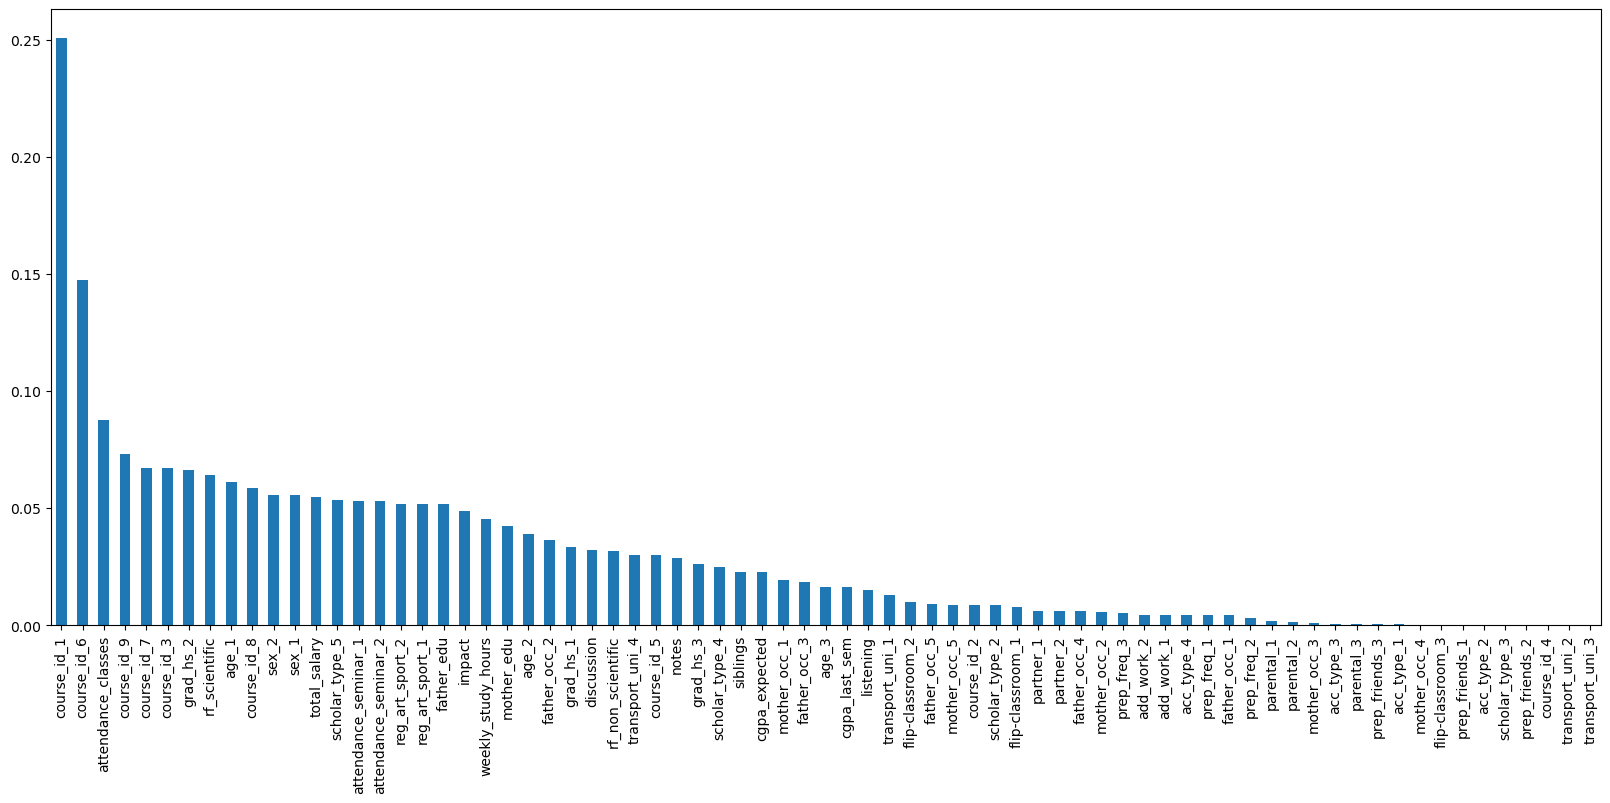

In [33]:
# Plot
mutual_info.sort_values(ascending = False).plot.bar(figsize =(20,8))

In [34]:
# Select the best features
best = mutual_info.index[0:14].to_list()

# Preview
best

['course_id_1',
 'course_id_6',
 'attendance_classes',
 'course_id_9',
 'course_id_7',
 'course_id_3',
 'grad_hs_2',
 'rf_scientific',
 'age_1',
 'course_id_8',
 'sex_2',
 'sex_1',
 'total_salary',
 'scholar_type_5']

> **I varied the number of features selected and ran the model. I saw that choosing around 14 features gave me the highest model accuracy.**

I made sure that when changing the random_state of `mutual_info_classif`, i get the same top 14 important features consistently.

In [35]:
# Filtering features
X_train = X_train[best]

X_test = X_test[best]

X_train.head()

,course_id_1,course_id_6,attendance_classes,course_id_9,course_id_7,course_id_3,grad_hs_2,rf_scientific,age_1,course_id_8,sex_2,sex_1,total_salary,scholar_type_5
0,0.0,0.0,3,1.0,0.0,0.0,0.0,2,1.0,0.0,0.0,1.0,1,1.0
1,1.0,0.0,3,0.0,0.0,0.0,1.0,2,1.0,0.0,1.0,0.0,1,1.0
2,0.0,0.0,3,0.0,1.0,0.0,1.0,2,1.0,0.0,1.0,0.0,1,0.0
3,0.0,0.0,3,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0,1,0.0
4,1.0,0.0,2,0.0,0.0,0.0,1.0,2,1.0,0.0,1.0,0.0,1,0.0


<Axes: >

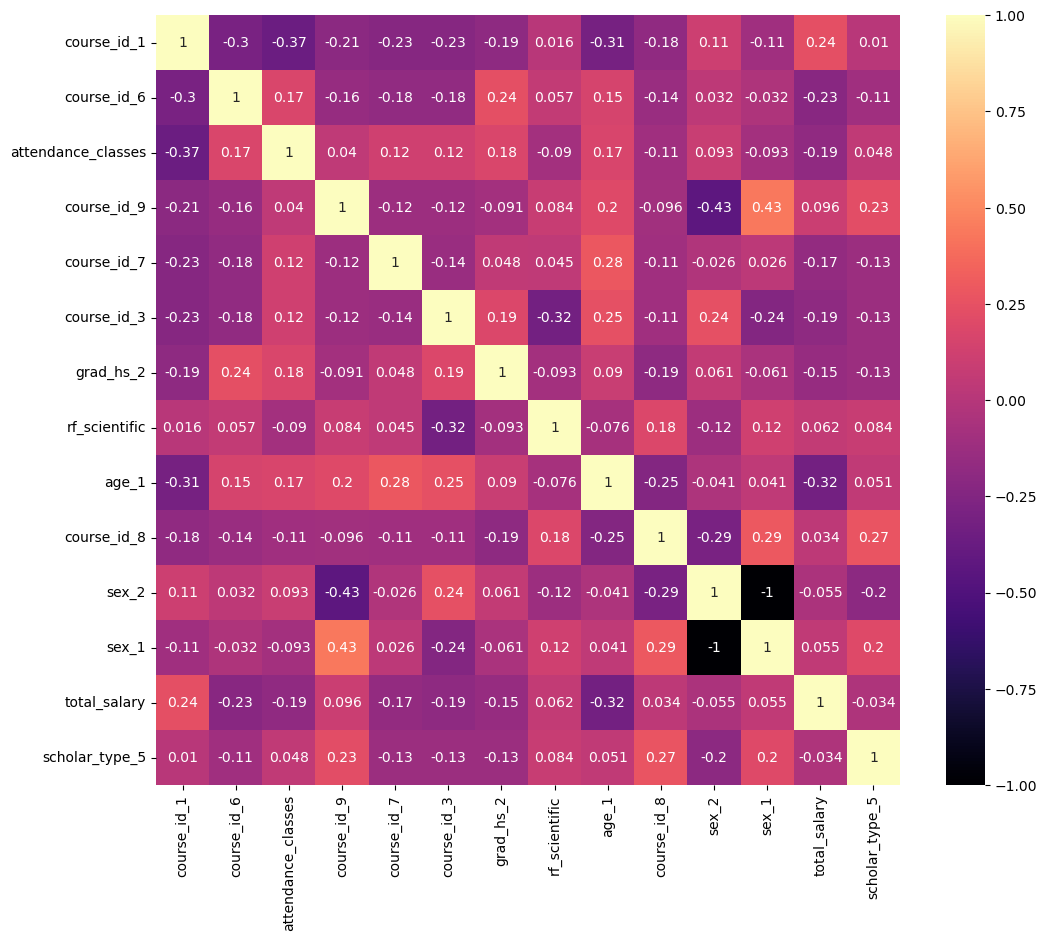

In [36]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(),annot=True,cmap='magma')

Here, `sex_1` and `sex_2` are perfectly collinear. But I am not removing it as the regularization of linear classification models will handle it.

## Modelling

We will be first testing multiple classifier models to compare.

In [37]:
# List of models to compare
models = {
    'Logistic Regression':LogisticRegression(random_state=43),
    'Linear SVC':LinearSVC(random_state=45),
    'Decision Tree':DecisionTreeClassifier(random_state=43),
    'K-nearest Neighbhour':KNeighborsClassifier(),
    'Random Forest':RandomForestClassifier(random_state=43)
}

score = {}

In [38]:
for i in range(len(list(models))):
    
    #Select model
    model = list(models.values())[i]
    
    # Train model
    model.fit(X_train,y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    
    print('Model performance for training set \n')
    
    print(f" Training performance of {list(models.keys())[i]}: \n",classification_report(y_train, y_train_pred))
    
    print('Model performance for testing set \n')
    
    print(f" Testing performance of {list(models.keys())[i]}: \n",classification_report(y_test, y_test_pred))
    
    print("ROC-AUC score:",round(roc_auc_score(y_test,y_test_pred),3))
    
    print('='*35)
    
    # Store in dictionary
    score[list(models.keys())[i]] = round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2)

Model performance for training set 

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        82
           1       0.95      1.00      0.98        82

    accuracy                           0.98       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.98      0.98       164

Model performance for testing set 

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91        33
           1       0.86      0.55      0.67        11

    accuracy                           0.86        44
   macro avg       0.86      0.76      0.79        44
weighted avg       0.86      0.86      0.85        44

ROC-AUC score: 0.758
Model performance for training set 

 Training performance of Linear SVC: 
               precision    recall  f1-score   support

           0       1.00   

**Metric - F1 score**

- I chose **F1 score** as our metric since accuracy is a poor metric for unbalanced data. 

- F1-score was chosen over precison or recall since in this use case, we are equally interested in minimising False Positives and False Negatives.

- I specifically chose **macro average of F1-score** since the f1-score for each individual class is varying significantly. For weighted average, resulting performance is based on the proportion of every class. So in order to prevent f1 score of one class significantly biasing the average, i chose macro average since it does not consider the proportion of classes.

In [39]:
# Model accuracy
pd.DataFrame(score.items(),columns = ['model','test_f1_score']).sort_values('test_f1_score',ascending=False)

,model,test_f1_score
1,Linear SVC,0.87
4,Random Forest,0.81
0,Logistic Regression,0.79
2,Decision Tree,0.76
3,K-nearest Neighbhour,0.74


> **Linear Support Vector Classifier had the highest test accuracy and ROC-AUC score. We see that SVM and Tree-based models capture the trends better.**

I chose Linear SVC model for multiple reasons:-

1. Dataset Size: Random Forest typically performs better with larger datasets due to its ability to capture complex relationships. In contrast, Linear SVC can handle small datasets reasonably well as it seeks to find a linear decision boundary that separates the classes.

2. Interpretability: Linear SVC is generally more interpretable than Random Forest. Linear SVC provides coefficients for each feature, which can indicate their importance in the classification process. Random Forest, being an ensemble of trees, is harder to interpret due to its complex structure.

3. Training and Inference Time: Linear SVC is generally faster to train and infer on small datasets compared to Random Forest, as the latter involves building multiple decision trees.

### Final Model

I chose to do hyperparameter tuning manually and found that the simple default values worked best.

A `L2 Regularization` is done when fitting the model which will help in reducing overfitting and doing feature selection. It will also handle multicollinearity between features. 

In [40]:
# Logistic Regression (OnevsRest classifier for mutliclass)
lsvc = LinearSVC(penalty = 'l2',loss ='squared_hinge', intercept_scaling=1, C=1, random_state=43)

lsvc.fit(X_train,y_train)

# Make predictions
y_train_pred = lsvc.predict(X_train)
y_test_pred = lsvc.predict(X_test)

print(f" Training performance of Logistic Regression: \n",classification_report(y_train, y_train_pred))

print(f" Testing performance of Logistic Regression: \n",classification_report(y_test, y_test_pred))

 Training performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        82
           1       0.96      1.00      0.98        82

    accuracy                           0.98       164
   macro avg       0.98      0.98      0.98       164
weighted avg       0.98      0.98      0.98       164

 Testing performance of Logistic Regression: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.89      0.73      0.80        11

    accuracy                           0.91        44
   macro avg       0.90      0.85      0.87        44
weighted avg       0.91      0.91      0.91        44



In [41]:
print("Training f1-score :",round(classification_report(y_train, y_train_pred,output_dict=True)['macro avg']['f1-score'],2))

print("Testing f1-score :",round(classification_report(y_test, y_test_pred,output_dict=True)['macro avg']['f1-score'],2))

print("ROC-AUC score:",round(roc_auc_score(y_test,y_test_pred),3))

Training f1-score : 0.98
Testing f1-score : 0.87
ROC-AUC score: 0.848


**Model Performance**

The model got a testing accuracy of 87% for predicting the student grade with a training accuracy of 98%. The model is overfitting, although not as severe as with the previous multi-class classification model.

The model has a ROC-AUC score of almost 85% which indicates that the model's performance is generally reliable.

However, changing the `random_state` of train-test-split still gives varying results, which means that there is a need of increased sample size for more stable accuracy values.

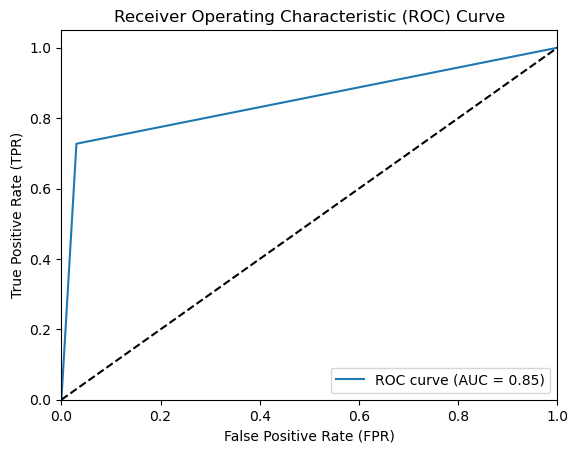

In [42]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Individual class scores
score = {}
precision = []
recall = []
support = []

for i in range(0,2):
    
    # Get f1 score
    score[i] = round(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['f1-score'],2)
    
    # Get support
    precision.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['precision'])
    
    # Get support
    recall.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['recall'])
    
    # Get support
    support.append(classification_report(y_test, y_test_pred,output_dict=True)[str(i)]['support'])

# Append to dataframe   
out = pd.DataFrame(score.items(),columns = ['Class','Test_f1_score'])

# Add precision column
out['Precision'] = [round(x,2) for x in precision]

# Add recall column
out['Recall'] = [round(x,2) for x in recall]

# Add support column
out['Support'] = support

print('Scores for each class: \n')

# Preview
out[['Class','Support','Precision','Recall','Test_f1_score']].sort_values('Test_f1_score',ascending=False).reset_index(drop=True)

Scores for each class: 



,Class,Support,Precision,Recall,Test_f1_score
0,0,33,0.91,0.97,0.94
1,1,11,0.89,0.73,0.80


Looking at the individual f1 scores for each class, we see that class 0 has 94% accuracy and class 1 (`High performing Students`) have 80% accuracy.

Class 1 has 89% precision. Almost 90% of the students who were predicted to be High performing students were High performing.

Similarly, Class 0 has 91% precision. Almost 90% of the students who were predicted to be Non-High performing students were Non-High performing.

Class 0 had 97% recall. Almost all the students that were not predicted to not be Non-high performing were not Non-high performing students.

However, Class 1 had only 73% recall. This means more than quarter (27%) of the students who were not predicted to be high performing were actually high performing students..

> **The model is better at predicting the non-high performing students.**

In [44]:
# Grade labels
label = {
    0:'Non-High Performing Students',
    1:'High Performing Students',
}

# Replace values
out['Grade'] = out.Class.replace(label)

# Drop class column
out = out.drop('Class', axis=1)

# Preview
out[['Grade','Support','Precision','Recall','Test_f1_score']].sort_values('Test_f1_score',ascending=False).reset_index(drop=True)

,Grade,Support,Precision,Recall,Test_f1_score
0,Non-High Performing Students,33,0.91,0.97,0.94
1,High Performing Students,11,0.89,0.73,0.80


## Conclusion


After comparing different classifications, Linear Support Vector Classification was used due to it performing the best and other considerations such as dataset size, interpretability and training time.

> **The binary classification model significantly outperforms the multiclass classification model due to the reduction in complexity.**

Due to the dataset being relatively small and imbalanced, different test-train data splits leads to variations in the representation of classes or important patterns in the data. This heavily impacts the model's ability to generalize and result in varying accuracy values.

The model had a test accuracy of 98% with a train accuracy of 87% and a roc-auc score of 85%. The model is better at predicting the non-high performing students. 

**The model is significantly bottlenecked by sample size. If the sample size of training dataset was increased, we could expect to have a much more accurate and reliable model.**

## Export model

In [45]:
# Model filename
filename = r'binary_model.pickle'

In [46]:
# Export file
pk.dump(lsvc, open(EXPORT+filename, 'wb'))